In [1]:
import my_library.common_analysis_tools as tools
import my_library.kinematic_cuts as kcuts
import my_library.constants as constants
import ROOT
import numpy as np

Welcome to JupyROOT 6.24/04


In [2]:
@ROOT.Numba.Declare(['float', 'float', 'float'], 'float')
def get_theta(px, py, pz):
    return np.degrees(np.arctan2(np.sqrt(px**2 + py**2), pz))

@ROOT.Numba.Declare(['float', 'float'], 'float')
def get_phi(px, py):
    return np.degrees(np.arctan2(py, px))


In [3]:
def make_kinematics_hists(particle, df, pxmin=-2.0, pxmax=2.0, pymin=-2.0, pymax=2.0, pzmin=-2.0, pzmax=2.0, pmin=-2.0, pmax=2.0, thetamin=0.0, thetamax=180.0, bin_size_p=0.01, bin_size_theta=1.0):
        n_bins_px = int((pxmax - pxmin) / bin_size_p)
        n_bins_py = int((pymax - pymin) / bin_size_p)
        n_bins_pz = int((pzmax - pzmin) / bin_size_p)
        n_bins_p = int((pmax - pmin) / bin_size_p)
        n_bins_theta = int((thetamax - thetamin) / bin_size_theta)

        hist_px = df.Histo1D((f'{particle}_px', f'{particle}_px', n_bins_px, pxmin, pxmax), f'{particle}_px')
        hist_py = df.Histo1D((f'{particle}_py', f'{particle}_py', n_bins_py, pymin, pymax), f'{particle}_py')
        hist_pz = df.Histo1D((f'{particle}_pz', f'{particle}_pz', n_bins_pz, pzmin, pzmax), f'{particle}_pz')
        hist_p = df.Define('p', f'sqrt({particle}_px*p_px + {particle}_py*p_py + {particle}_pz*p_pz)').Histo1D((f'{particle}_p', f'{particle}_p', n_bins_p, pmin, pmax), 'p')
        hist_theta = df.Define('theta', f'Numba::get_theta({particle}_px, {particle}_py, {particle}_pz)').Histo1D((f'{particle}_theta', f'{particle}_theta', n_bins_theta, thetamin, thetamax), 'theta')
        hist_phi = df.Define('phi', f'Numba::get_phi({particle}_px, {particle}_py)').Histo1D((f'{particle}_phi', f'{particle}_phi', 370, -185.0, 185.0), 'phi')
        return hist_px, hist_py, hist_pz, hist_p, hist_theta, hist_phi


def get_kinematics(channel: str, particle: str, df: ROOT.RDataFrame, pxmin=-2.0, pxmax=2.0, pymin=-2.0, pymax=2.0, pzmin=-2.0, pzmax=2.0, pmin=-2.0, pmax=2.0, thetamin=0.0, thetamax=180.0, bin_size_p=0.01, bin_size_theta=1.0):
    if particle not in ['proton', 'kaon', 'pion', 'kshort_pi+', 'kshort_pi-']:
        print(f'Particle {particle}_{channel} not supported')
        raise ValueError(f'Acceptable particles are proton, kaon, pion, kshort_pi+, kshort_pi-')
    if channel not in ['pipkmks', 'pimkpks']:
        print(f'Channel {channel} not supported')
        raise ValueError(f'Acceptable channels are pipkmks, pimkpks')
    
    if channel == 'pipkmks':
        kaon = 'km'
        pion = 'pip1'
        ks_pip = 'pip2'
        ks_pim = 'pim'
    elif channel == 'pimkpks':
        kaon = 'kp'
        pion = 'pim1'
        ks_pip = 'pip'
        ks_pim = 'pim2'

    if particle == 'proton':
        return make_kinematics_hists('p', df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta)
    elif particle == 'kaon':
        return make_kinematics_hists(kaon, df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta)
    elif particle == 'pion':
        return make_kinematics_hists(pion, df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta)
    elif particle == 'kshort_pi+':
        return make_kinematics_hists(ks_pip, df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta)
    elif particle == 'kshort_pi-':
        return make_kinematics_hists(ks_pim, df, pxmin=pxmin, pxmax=pxmax, pymin=pymin, pymax=pymax, pzmin=pzmin, pzmax=pzmax, pmin=pmin, pmax=pmax, thetamin=thetamin, thetamax=thetamax, bin_size_p=bin_size_p, bin_size_theta=bin_size_theta)
    

In [36]:
run_period = 'spring'
data_type = 'signal'
df_pipkmks = tools.get_dataframe('pipkmks', run_period, data_type)
df_pimkpks = tools.get_dataframe('pimkpks', run_period, data_type)

In [37]:
df_pipkmks = df_pipkmks.Filter(kcuts.KSTAR_ALL_CUT_PIPKMKS).Filter('pipkmks_m > 1.24 && pipkmks_m < 1.35')
df_pimkpks = df_pimkpks.Filter(kcuts.KSTAR_ALL_CUT_PIMKPKS).Filter('pimkpks_m > 1.24 && pimkpks_m < 1.35')

In [38]:
print(df_pipkmks.GetColumnNames())

{ "p_pt", "p_p", "ks_px", "ks_py", "ks_pz", "ks_E", "ks_m", "ks_px_measured", "ks_py_measured", "ks_pz_measured", "ks_E_measured", "ks_m_measured", "mxpx_ppipkmks", "mxpy_ppipkmks", "mxpz_ppipkmks", "mxe_ppipkmks", "mx2_ppipkmks", "ppip_px", "ppip_py", "ppip_pz", "ppip_E", "ppip_m", "missing_px", "missing_py", "missing_pz", "missing_E", "missing_m", "kmp_px", "kmp_py", "kmp_pz", "kmp_E", "kmp_m", "ksp_px", "ksp_py", "ksp_pz", "ksp_E", "ksp_m", "kspip_px", "kspip_py", "kspip_pz", "kspip_E", "kspip_m", "kmpip_px", "kmpip_py", "kmpip_pz", "kmpip_E", "kmpip_m", "pipkmks_px", "pipkmks_py", "pipkmks_pz", "pipkmks_E", "pipkmks_px_measured", "pipkmks_py_measured", "pipkmks_pz_measured", "pipkmks_pt", "pipkmks_p_pt_diff", "pipkmks_m", "kmks_px", "kmks_py", "kmks_pz", "kmks_E", "kmks_m", "e_bin", "t_bin", "run", "event", "weight", "numtruepid_final", "truepids_decay", "is_truetop", "is_truecombo", "is_bdtcombo", "rftime", "kin_chisq", "kin_ndf", "beam_beamid", "beam_isgen", "beam_x4_meas", "beam

### Proton Kinematics

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


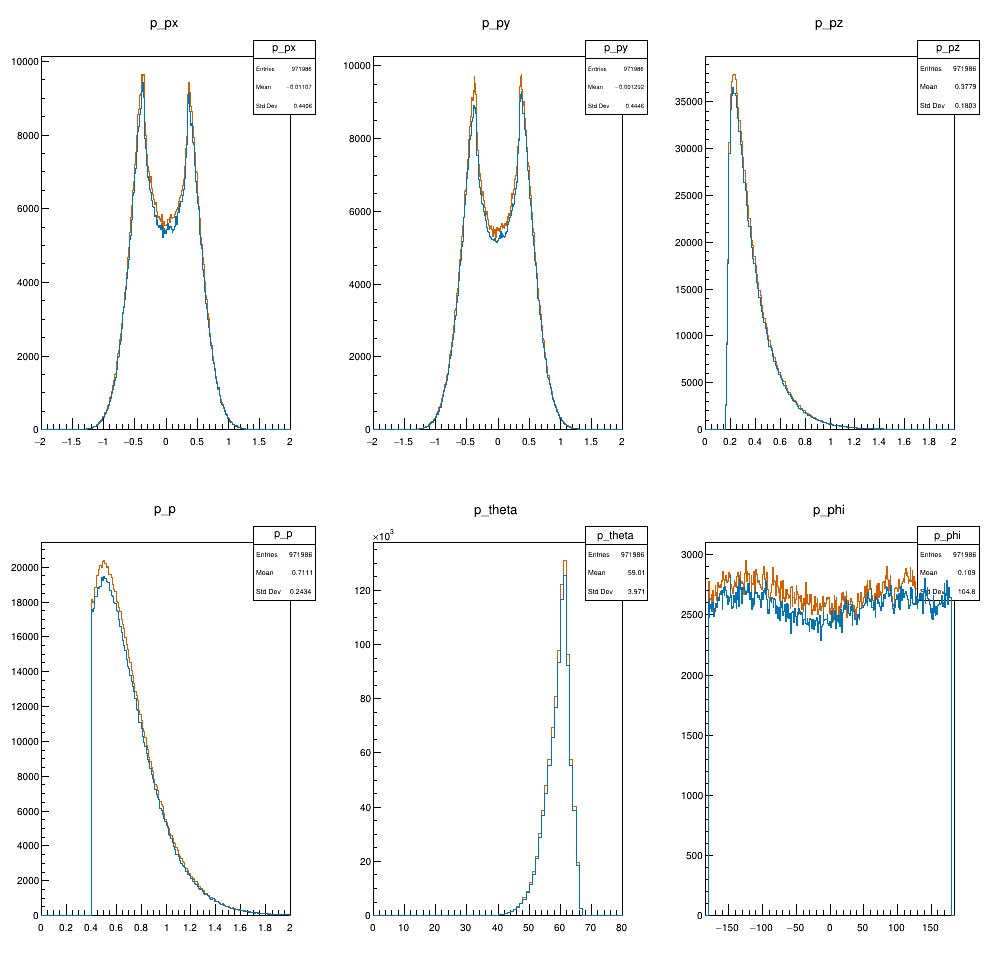

In [39]:
c = ROOT.TCanvas("c", "c", 1000, 1000)
c.Divide(3, 2)

proton_hists_pipkmks = get_kinematics('pipkmks', 'proton', df_pipkmks, pmin=0.0, pzmin=0.0, thetamin=0.0, thetamax=80)
proton_hists_pimkpks = get_kinematics('pimkpks', 'proton', df_pimkpks, pmin=0.0, pzmin=0.0, thetamin=0.0, thetamax=80)
for i, hist_pipkmks in enumerate(proton_hists_pipkmks):
    c.cd(i+1)
    hist_pimkpks = proton_hists_pimkpks[i]
    hist_pimkpks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    # hist_pipkmks.Scale(1.0/hist_pipkmks.Integral())
    # hist_pimkpks.Scale(1.0/hist_pimkpks.Integral())
    hist_pimkpks.Draw()
    hist_pipkmks.Draw('same')
c.Draw()

### Kaon Kinematics

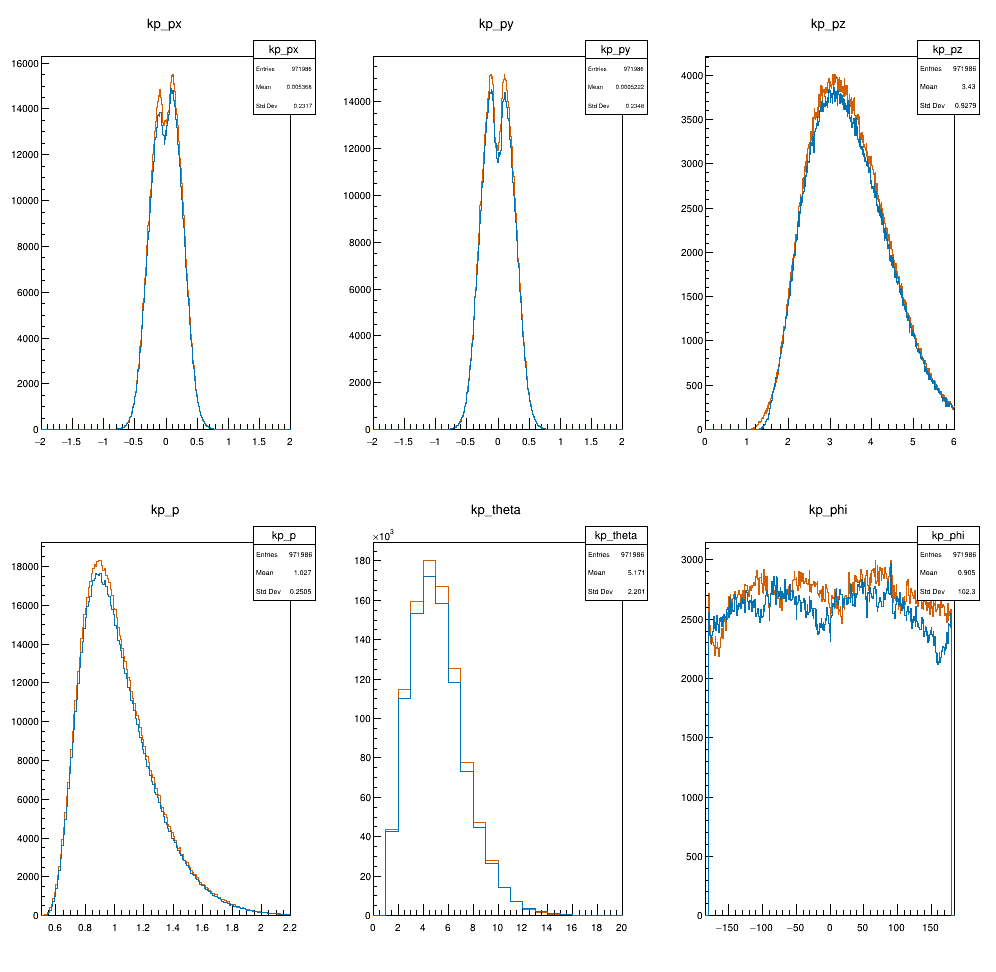

In [40]:
kaon_hists_pipkmks = get_kinematics('pipkmks', 'kaon', df_pipkmks, pzmin=0.0, pzmax=6.0, pmin=0.5, pmax=2.2, thetamax=20)
kaon_hists_pimkpks = get_kinematics('pimkpks', 'kaon', df_pimkpks, pzmin=0.0, pzmax=6.0, pmin=0.5, pmax=2.2, thetamax=20)
for i, hist_pipkmks in enumerate(kaon_hists_pipkmks):
    c.cd(i+1)
    hist_pimkpks = kaon_hists_pimkpks[i]
    hist_pimkpks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    # hist_pipkmks.Scale(1.0/hist_pipkmks.Integral())
    # hist_pimkpks.Scale(1.0/hist_pimkpks.Integral())
    hist_pimkpks.Draw()
    hist_pipkmks.Draw('same')
c.Draw()

### Pion Kinematics

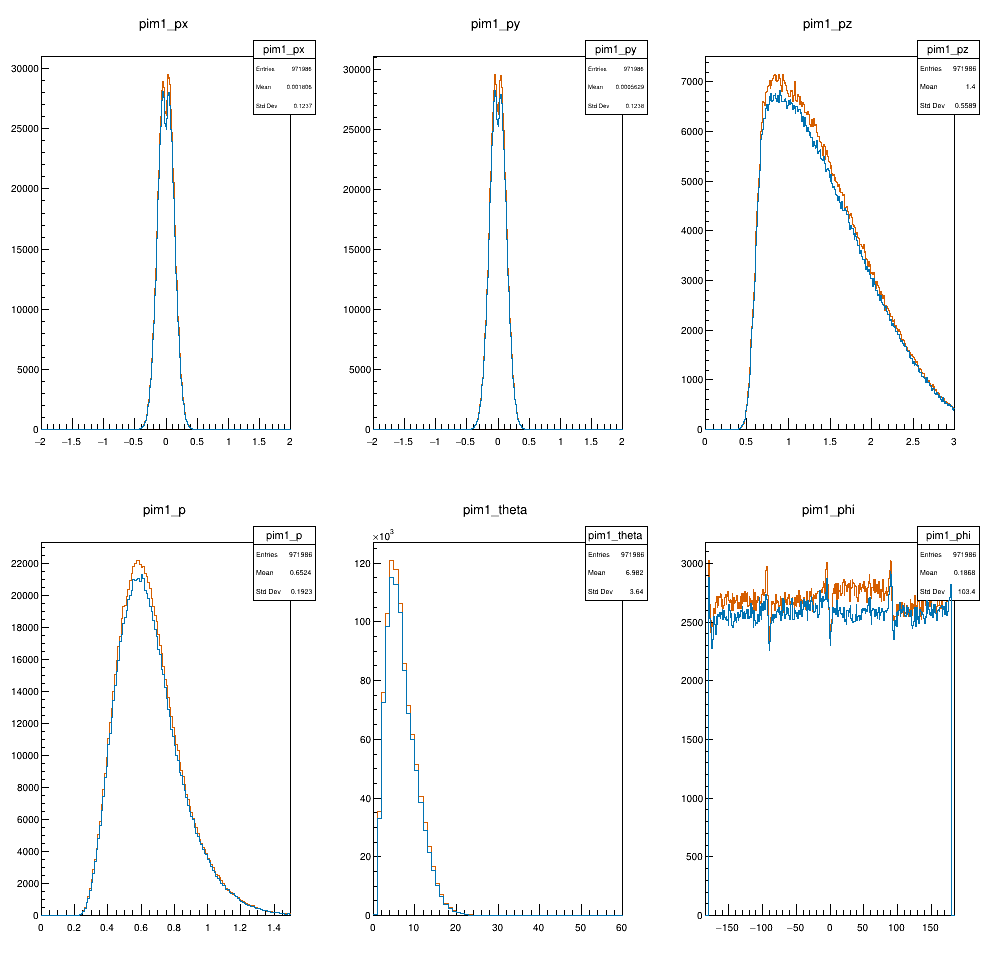

In [41]:
pion_hists_pipkmks = get_kinematics('pipkmks', 'pion', df_pipkmks, pzmin=0.0, pzmax=3.0, pmin=0.0, pmax=1.5, thetamax=60)
pion_hists_pimkpks = get_kinematics('pimkpks', 'pion', df_pimkpks, pzmin=0.0, pzmax=3.0, pmin=0.0, pmax=1.5, thetamax=60)
for i, hist_pipkmks in enumerate(pion_hists_pipkmks):
    c.cd(i+1)
    hist_pimkpks = pion_hists_pimkpks[i]
    hist_pimkpks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    # hist_pipkmks.Scale(1.0/hist_pipkmks.Integral())
    # hist_pimkpks.Scale(1.0/hist_pimkpks.Integral())
    hist_pimkpks.Draw()
    hist_pipkmks.Draw('same')
c.Draw()

### KShort Pi+ Kinematics

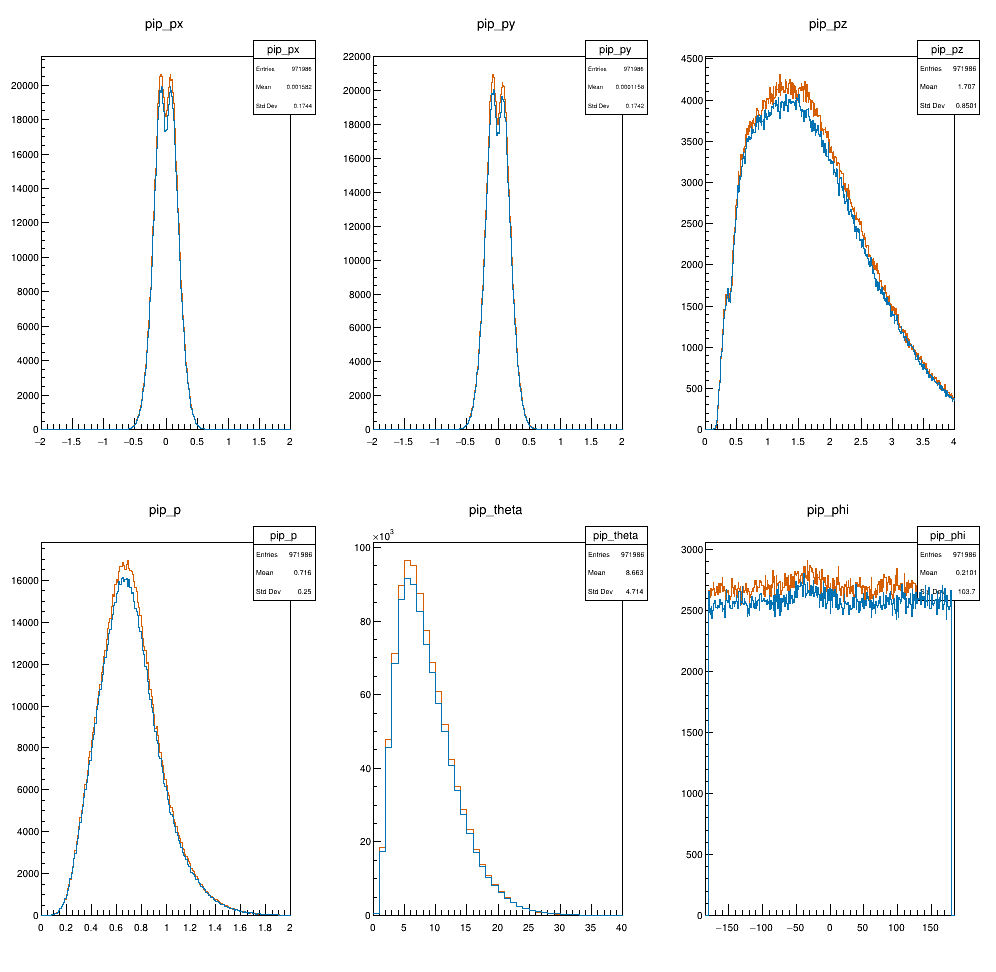

In [42]:
kspip_hists_pipkmks = get_kinematics('pipkmks', 'kshort_pi+', df_pipkmks, pzmin=0.0, pzmax=4.0, pmin=0.0, thetamax=40)
kspip_hists_pimkpks = get_kinematics('pimkpks', 'kshort_pi+', df_pimkpks, pzmin=0.0, pzmax=4.0, pmin=0.0, thetamax=40)
for i, hist_pipkmks in enumerate(kspip_hists_pipkmks):
    c.cd(i+1)
    hist_pimkpks = kspip_hists_pimkpks[i]
    hist_pimkpks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    # hist_pipkmks.Scale(1.0/hist_pipkmks.Integral())
    # hist_pimkpks.Scale(1.0/hist_pimkpks.Integral())
    hist_pimkpks.Draw()
    hist_pipkmks.Draw('same')
c.Draw()

### KShort Pi- Kinematics

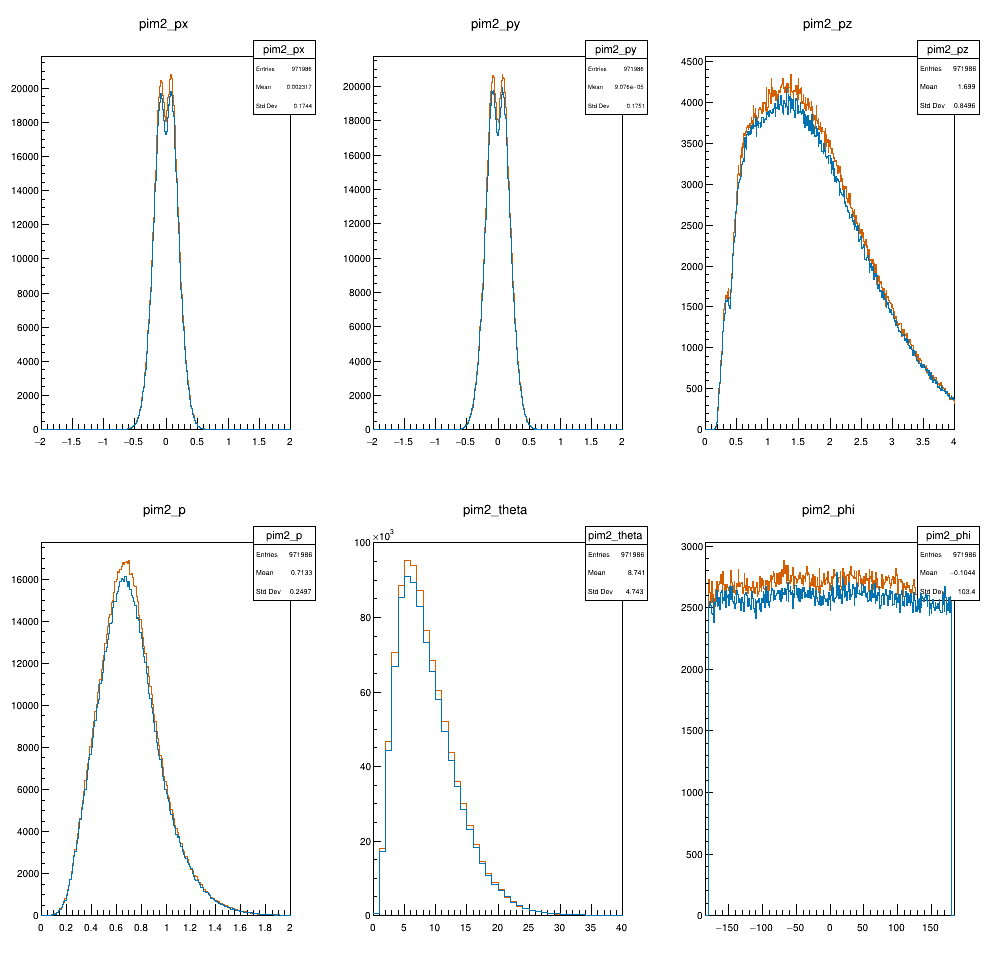

In [43]:
kspim_hists_pipkmks = get_kinematics('pipkmks', 'kshort_pi-', df_pipkmks, pzmin=0.0, pzmax=4.0, pmin=0.0, thetamax=40)
kspim_hists_pimkpks = get_kinematics('pimkpks', 'kshort_pi-', df_pimkpks, pzmin=0.0, pzmax=4.0, pmin=0.0, thetamax=40)
for i, hist_pipkmks in enumerate(kspim_hists_pipkmks):
    c.cd(i+1)
    hist_pimkpks = kspim_hists_pimkpks[i]
    hist_pimkpks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['red']))
    hist_pipkmks.SetLineColor(ROOT.TColor.GetColor(constants.COLORBLIND_HEX_DICT['blue']))
    # hist_pipkmks.Scale(1.0/hist_pipkmks.Integral())
    # hist_pimkpks.Scale(1.0/hist_pimkpks.Integral())
    hist_pimkpks.Draw()
    hist_pipkmks.Draw('same')
c.Draw()